In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tools
import pandas as pd
import healpy as hp
from pixell import enmap, curvedsky
from orphics import io, maps, lensing, cosmology, stats
from symlens import utils

In [2]:
# map source
map_source = 'websky'
# ksz type
ksz_type = 'ri'
# experiment configuration
experiment_name = 'CMB_S4'
if experiment_name == 'CMB_S4':
    nlev_t =1
    beam_arcmin = 3

In [34]:
plot_path = 'plots/'

In [4]:
# lmin, lmax for cmb maps
ellmin, ellmax = 100, 4000
# lmin, lmax for reconstructed kappa map
Lmin, Lmax = 40, 4000
# bin width for reconstructed kappa powerspectrum
delta_L = 40

# noise level for temperature and polarization maps, here we only investiget temperature maps
nlev_t = 0
nlev_p = np.sqrt(2)*nlev_t
# beam size
beam_arcmin = 1
# pixel size in arcmin
px_arcmin = 1.
# size of cutout square
width_deg = 30

# Let's define a cut-sky cylindrical geometry with 1 arcminute pixel width
# and a maximum declination extent of +- 15 deg (see below for reason)
# band width in deg
decmax = 30
# shape and wcs  of the band
band_shape, band_wcs = enmap.band_geometry(dec_cut=np.deg2rad(decmax),
                                 res=np.deg2rad(px_arcmin / 60.))

band_modlmap = enmap.modlmap(band_shape, band_wcs)

In [12]:
class recon_lens():
    """ Get auto powerspectrum of two reconstructed kappa maps and compare the bias """
    def __init__(self, ellmin, ellmax, nlev_t, beam_arcmin, px_arcmin, width_deg, cmb1=None, theory_cl=None):

        self.cmb1 = cmb1
        self.ellmin = ellmin
        self.ellmax = ellmax
        self.nlev_t = nlev_t
        self.beam_arcmin = beam_arcmin
        self.px_arcmin = px_arcmin
        self.width_deg = width_deg

        self.shape = self.cmb1.shape
        self.wcs = self.cmb1.wcs

        # npix x npix cutouts
        self.npix = int(width_deg * 60 / self.px_arcmin)
        # total number of tiles
        self.ntiles = int(np.prod(self.shape) / self.npix**2)
        # number of tiles in a row
        self.num_x = int(360 / self.width_deg)

        # Get Cl_TT in theory for symlens, it is same for each cutout
        self.theory = cosmology.default_theory()
        #self.theory_cl = theory_cl
    def auto(self, Lmin, Lmax, delta_L):
        """
        Get cutout reconstructed kappa auto-power or cross-power with input cutout kappa
        """
        # for statistics
        st = stats.Stats()
        # Initialize upper-left pixel corner
        iy, ix = 0, 0



        for itile in range(self.ntiles):
            # Get bottom-right pixel corner
            ey = iy + self.npix
            ex = ix + self.npix

            # Slice both cmb maps
            cut_cmb1 = self.cmb1[iy:ey, ix:ex]

            # Get geometry of the cutouts, I assume cut_cmb1 and cut_cmb2 have same geometry
            cut_shape = cut_cmb1.shape
            cut_wcs = cut_cmb1.wcs
            cut_modlmap = enmap.modlmap(cut_shape, cut_wcs)
            ells = np.arange(0, cut_modlmap.max()+1, 1)
            ctt = self.theory.lCl('TT', ells)
            #ctt = self.theory_cl[ells]

            # Get taper for appodization
            taper, w2 = maps.get_taper_deg(cut_shape, cut_wcs)

            # Define feed_dict for symlens
            feed_dict = {}
            feed_dict['uC_T_T'] = utils.interp(ells,
                                               ctt)(cut_modlmap)
            feed_dict['tC_T_T'] = utils.interp(ells, ctt)(
                cut_modlmap) + (self.nlev_t * np.pi / 180. /
                                60.)**2. / utils.gauss_beam(
                                    cut_modlmap, self.beam_arcmin)**2

            # Get cmb mask
            cmask = utils.mask_kspace(cut_shape,cut_wcs,lmin=self.ellmin,lmax=self.ellmax)
            # Get mask for reconstruction
            kmask = utils.mask_kspace(cut_shape,cut_wcs,lmin=Lmin,lmax=Lmax)
            # Stride across the map, horizontally first and
            # increment vertically when at the end of a row
            if (itile + 1) % self.num_x != 0:
                ix = ix + self.npix
            else:
                ix = 0
                iy = iy + self.npix

            # Apodize cutout CMB maps
            cut_cmb1 = taper * cut_cmb1

            # Get the Fourier maps
            cut_cmb1_k = enmap.fft(cut_cmb1, normalize='phys')
        
            # Reconstruct kappa fourier maps
            cut_reckap1, noise_2d = tools.cutout_rec(cut_shape, cut_wcs, feed_dict, cmask, kmask, cut_cmb1_k, cut_cmb1_k)

            # Get auto powerspectra
            center_L, cut_reckap1_x_reckap1 = tools.powspec(cut_reckap1, cut_reckap1, taper, 4, cut_modlmap, Lmin, Lmax, delta_L)
        
            # Add to stats
            st.add_to_stats('reckap1 x reckap1', cut_reckap1_x_reckap1)

        # Get spectra and bias statistics
        st.get_stats()

        return center_L, st

In [7]:
# Read in ksz_alm and get ksz band map
colin_ksz_lt_alm = hp.read_alm('maps/Colin/ksz_lt_alm.fits')
colin_ksz_lt_band = curvedsky.alm2map(colin_ksz_lt_alm, enmap.empty(band_shape, band_wcs))

In [8]:
websky_ksz_ri_alm = hp.read_alm('maps/websky/ksz_ri_alm.fits')
websky_ksz_ri_band = curvedsky.alm2map(websky_ksz_ri_alm, enmap.empty(band_shape, band_wcs))

In [9]:
websky_ksz_lt_alm = hp.read_alm('maps/websky/ksz_lt_alm.fits')
websky_ksz_lt_band = curvedsky.alm2map(websky_ksz_lt_alm, enmap.empty(band_shape, band_wcs))

In [13]:
Ls1, Recon1 = recon_lens(ellmin, ellmax, nlev_t, beam_arcmin, px_arcmin, width_deg, cmb1=colin_ksz_lt_band).auto(Lmin, Lmax, delta_L)
Ls2, Recon2 = recon_lens(ellmin, ellmax, nlev_t, beam_arcmin, px_arcmin, width_deg, cmb1=websky_ksz_lt_band).auto(Lmin, Lmax, delta_L)
Ls3, Recon3 = recon_lens(ellmin, ellmax, nlev_t, beam_arcmin, px_arcmin, width_deg, cmb1=websky_ksz_ri_band).auto(Lmin, Lmax, delta_L)

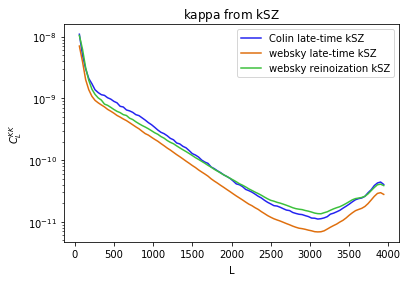

In [35]:
plt.plot(Ls1, Recon1.stats['reckap1 x reckap1']['mean'])
plt.plot(Ls2, Recon2.stats['reckap1 x reckap1']['mean'])
plt.plot(Ls3, Recon3.stats['reckap1 x reckap1']['mean'])
plt.legend(['Colin late-time kSZ', 'websky late-time kSZ', 'websky reinoization kSZ'])
plt.title(r'${\mathrm{kappa}}$ from kSZ')
plt.xlabel('$\mathrm{L}$')
plt.ylabel('$C_L^{KK}$')
plt.yscale('log')
plt.savefig(plot_path + 'ksz_kappa.png')